<a href="https://colab.research.google.com/github/sahilbaishya/MalariaDetection/blob/main/BuildCNNWithTensorflow_MalariaDaignosis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
import cv2
import albumentations as A

import seaborn as sns


# **Data Preparation**

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files=True,
                                  split=['train'])

In [ ]:
# for data in dataset[0].take(1):
#   print(data)

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# print(list(train_dataset.take(1).as_numpy_iterator()))
# print(list(val_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))
# dataset = dataset.take()
# list(dataset.as_numpy_iterator())

# **Data Visualization**

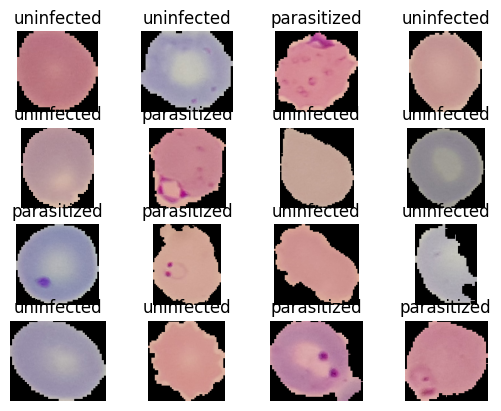

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(0)

'parasitized'

# **Data Prerocessing**

## Data Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.central_crop(original_image, central_fraction=0.8)

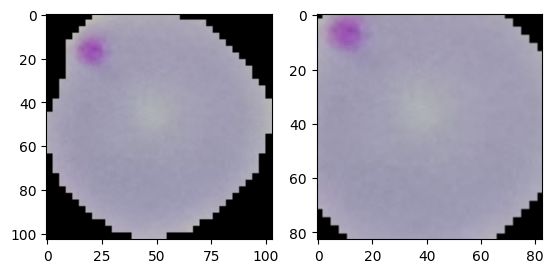

In [ ]:
visualize(original_image, augmented_image)

In [ ]:
# DATA PROCESSING

# data_standardization: x = (x-mean)/std
# data_normalization: x = (X - Xmin)/(Xmax - Xmin) = (X - 0)/(255 - 0) = X/255

# If we have a image where most of its pixels revolve around a particular mean value, then we would stantardize the data
# If pixel values are mostly different, we go with normalization

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
   return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
#resizing-rescaling using layers
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [ ]:
#data augmentation using tf.image
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image, k = tf.random.uniform(shape=[], minval = 0, maxval = 2, dtype=tf.int32))
  # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
  image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  # image = tf.image.flip_left_right(image)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [ ]:
#Such classes cna be used to implement augmentation with tf.keras.layers and
#at the same time using functionalities of tf.image
# This gives us flexibility of tf.image and speed and portability of tf.keras.layers also
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  def call(self, image):
    return tf.image.rot90(image,  k = tf.random.uniform(shape=[], minval = 0, maxval = 2, dtype=tf.int32))

In [ ]:
#augmentation using tf.keras.layer
augment_layers = tf.keras.Sequential([
    # RandomRotation(factor = (0.25, 0.2501), ), #the tf.keras.layer rotation func
    RotNinety(), #the tf.image rotation func wrapped in a class
    RandomFlip(mode = 'horizontal',),
    RandomContrast(factor=0.1),
])

def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [ ]:
# test_dataset = test_dataset.map(resize_rescale_layers)
#train_dataset

#### SINCE WE INCLUDED RESIZE RESCALE AND AUGMENTATION IN  THE MODEL ITSELF, NOW WE DONT NEED TO DO THEM SEPARATELY

## Data Loading

In [ ]:
# for image, label in train_dataset.take(1):
#   print(image, label)

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    # .map(augment_layer)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    # .map(resize_rescale_layers)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Mixup Data Augmentation



In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))



In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda * tf.cast(label_1, dtype= tf.float32) + (1-lamda)*tf.cast(label_2, dtype= tf.float32)

  return image, label



In [ ]:
# BATCH_SIZE = 32
# train_dataset = (
#     mixed_dataset
#     .shuffle(buffer_size=4096, reshuffle_each_iteration=True)
#     # .map(mixup)
#     .map(cutmix)
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
#     )

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
val_dataset = (
    val_dataset
    .map(resize_rescale_layers)
    .batch(1)
    )

In [ ]:
val_dataset

## Cutmix Data Augmentation

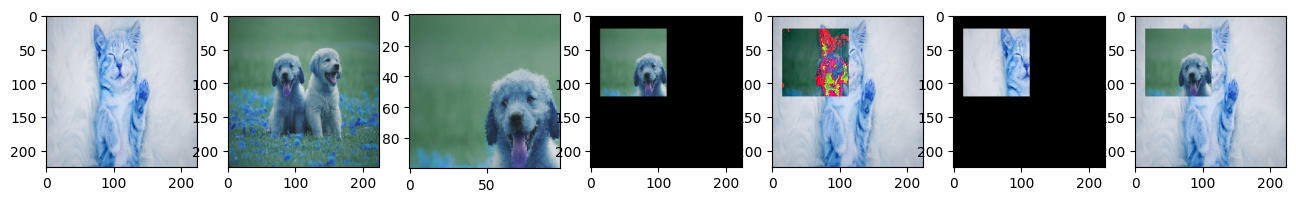

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,7,1)
image_1 = cv2.resize(cv2.imread('cute_cat.jpg'), (IM_SIZE, IM_SIZE))
plt.imshow(image_1)

plt.subplot(1,7,2)
image_2 = cv2.resize(cv2.imread('cute_dog.jpg'), (IM_SIZE, IM_SIZE))
plt.imshow(image_2)

plt.subplot(1,7,3)
crop = tf.image.crop_to_bounding_box(image_2, 20, 15, 100, 98)
plt.imshow(crop)

plt.subplot(1,7,4)
image_padded = tf.image.pad_to_bounding_box(crop, 20, 15, IM_SIZE, IM_SIZE)
plt.imshow(image_padded)

plt.subplot(1, 7, 5)
# image_padded = tf.image.pad_to_bounding_box(crop, 20, 15, IM_SIZE, IM_SIZE)
plt.imshow(image_padded + image_1)

plt.subplot(1,7,6)
crop_cat = tf.image.crop_to_bounding_box(image_1, 20, 15, 100, 98)
padded_cat = tf.image.pad_to_bounding_box(crop_cat, 20, 15, IM_SIZE, IM_SIZE)
plt.imshow(padded_cat)

plt.subplot(1, 7, 7)
# image_padded = tf.image.pad_to_bounding_box(crop, 20, 15, IM_SIZE, IM_SIZE)
final_image = image_padded + image_1 - padded_cat
plt.imshow(final_image)



In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)


  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)


  x_b_r = tf.clip_by_value(r_y + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  image_padded_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  image_padded_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_padded_2 + image_1 - image_padded_1

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label



In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size=4096, reshuffle_each_iteration=True)
    .map(cutmix)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
original_image, label = next(iter(train_dataset))
plt.imshow(original_image[1])

InvalidArgumentError: ignored

## Albumentations

In [ ]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([A.HorizontalFlip(), A.VerticalFlip(),], p=0.3),
    A.RandomRotate90(),
    # A.RandomGridShuffle(),
    A.RandomBrightnessContrast (brightness_limit = 0.2, contrast_limit = 0.2, brightness_by_max = True, always_apply=False, p=0.5),
    # A.Sharper(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p = 0.5),
    # A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5)
])

In [ ]:
def aug_albument(image):
  data= {"image": image}
  image= transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [ ]:
def process_data(image, label):
  aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
  return aug_img, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

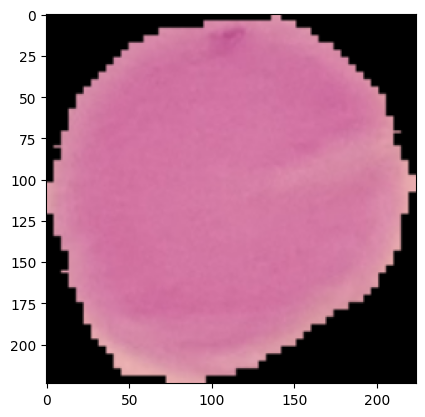

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

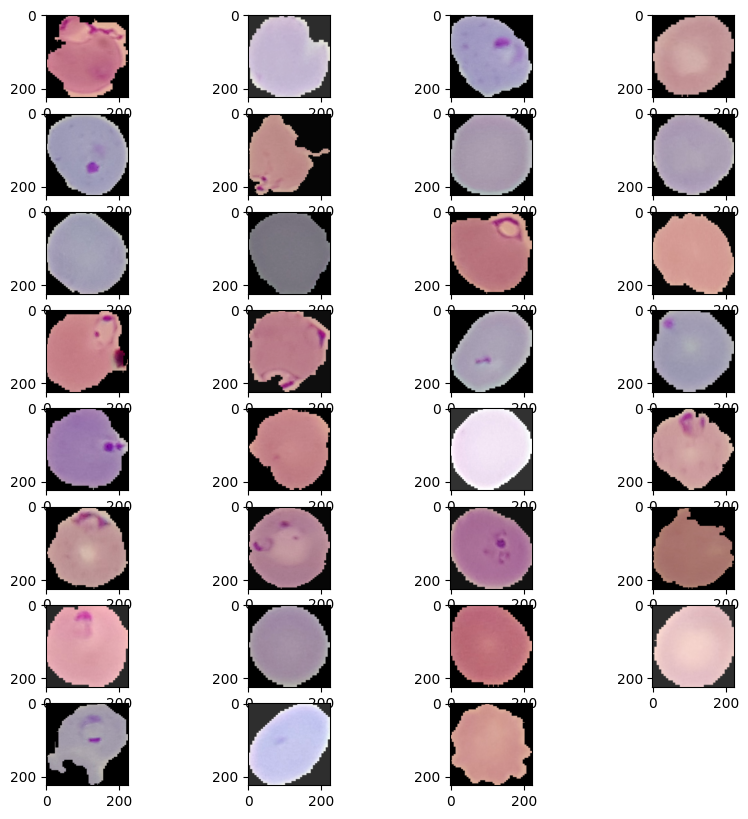

In [ ]:
plt.figure(figsize=(10,10))

for i in range(1, 32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])

# **Model Creation and Training**

## **Sequential Model**

In [ ]:
#Hyperparameters: InputSize, Padding(P), KernelSize (filter) (F), Stride(S)
# W(output) = (W(input) - F + 2P)/S + 1     ---formula for convolution

#2-D images- height and width (i.e. shape of the tensor)
#3-D images- R,G,B kernels also there

# X(output) = (X(input) - F)/S + 1    ---> Pooling formula

#Layers- Conv -> Pool -> Activation (Relu) -> Repeat seq --> Flat layer -> Dense layer
#Initial layers are for feature extraction, and later layers are for feature classification


#Conv Layers -> tf.keras

In [ ]:
from pickle import NONE
dropout_rate = 0.2
regularization_rate = 0.01
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),

    resize_rescale_layers,
    # augment_layers,

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu", kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = "relu", kernel_regularizer = L2(0.01)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

## **Functional API**

### Feature extractor

In [ ]:
#function api feature extractor
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = 'Feature_Extractor')
feature_extractor_model.summary()

In [ ]:
#sequential api feature extractor
feature_extractor_sequential_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2)

])

feature_extractor_sequential_model.summary()

### Callable Model

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')

x = feature_extractor_sequential_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

### Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = 2 * strides)

    self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2= MaxPool2D(pool_size = pool_size, strides = 2 * strides)

  def call(self, x):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

### Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units),initializer = "random_normal" ,trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal" ,trainable = True)

  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == 'relu'):
      return tf.nn.relu(pre_output)
    elif(self.activation == 'sigmoid'):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output


In [ ]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides = 2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(1, activation = "sigmoid"),

])

lenet_custom_model.summary()

# **Callbacks**

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch +1, logs['loss']))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {}".format(batch+1, logs))

### CSVLogger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

### Early Stopping



In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta = 0, patience = 0, verbose = 0,
    mode = 'auto', baseline=None, restore_best_weights=False
)

### Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

### Model Checkpoint

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/', monitor='val_loss', verbose=0, save_best_only = False,
    save_weights_only=False, mode = 'auto', save_freq = 3,
)

### ReduceLROnPlateau Call

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose =1
)

# **Model Training**

In [ ]:
# ERROR SANCTION: binarycrossentropy

In [ ]:
# y_true = [0.0, 0.0, 0.0]
# y_pred = [1.0, 1.0, 1.0]
# bce = BinaryCrossentropy()
# bce(y_true, y_pred)

In [ ]:
metrics = [TruePositives(name = 'tp'), FalsePositives(name='fp'),
           TrueNegatives(name = 'tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc')]

### Custom Loss Method (without parameters)

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

## Custom Loss Method (with parameters)

In [ ]:
FACTOR =1
def custom_bce(FACTOR):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss


## Custom Loss Class

In [ ]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

## Custom Metric Method (without parameters)

In [ ]:
from keras.metrics.accuracy_metrics import binary_accuracy
def custom_accuracy(y_true, y_pred):
  return binary_accuracy(y_true, y_pred)

## Model compile and fitting

In [ ]:
# lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
#               loss = BinaryCrossentropy(),
#               metrics = 'accuracy'
#               )

lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = custom_bce,
              metrics = metrics
              )

In [ ]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset,  epochs = 10, verbose =1, )

Epoch 1/10


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation and Testing**

In [ ]:
test_dataset = test_dataset.batch(1)


In [ ]:
test_dataset

In [ ]:
lenet_custom_model.evaluate(test_dataset)

**Visualizing Confusion Matrix**

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)
labels = np.array([i[0] for i in labels])
print(labels)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [ ]:
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

In [ ]:
threshold = 0.8368

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

**ROC Plots**

In [ ]:
fp, tp, threshold = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("Ture Positive rate")

plt.grid()

skip = 20

for i in range(0, len(threshold), skip):
  plt.text(fp[i], tp[i], threshold[i])
plt.show()

In [ ]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

# **Saving and Loading the model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
lenet_model.save('lenet')

In [ ]:
lenet_loaded_model = tf.keras.models.load_model('lenet')

In [ ]:
lenet_loaded_model.summary()

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_loaded_model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
lenet_loaded_model.evaluate(test_dataset)

# Notes




## True, false positives/negatives

Positive -> Parasitised
Negative -> Uninfected

False Negative -> positive is shown negative
False Positive -> negative is shown positive

In this case we will try to reduce the number of False Negatives since it will have more harmful effect then False Positive


Confusion Matrix-   TN(1,1)        FP(1,2)
                    FN(2,1)        TP(2,2)

Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
Accuracy = (TN + TP)/(TN + TP + FN + FP)
F1 Score = 2PR/(P+R)
Specificity = TN/(TN + FP)


To reduce values of FP & FN, we can change the value of threshold accordingly,
i.e. initially threshold was 0.5, i.e. >0.5 was parasitised, else not parasitised,
in this case to reduce the FN, we will reduce the threshold value below 0.5, so that more values give output as Parasitised and FN is reduced

We can get a suitable threshold by using the ROC plot [(TP/(TP+FN)) vs (FP/(FP + TN))]


## Overfitting

Early stopping: Point at which validation loss stops decreasing
Callback: let's us execute a certain function when a certain event occurs, like at the end of each epoch
CSVLogger: logs the callbacks in a csv file